In [1]:
import cv2
import numpy as np

def replace_bright_pixels(image_path, output_path):
    """
    Replaces pixels with all color channel values over 240 with pure white.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # Efficiently find bright pixels using NumPy
    bright_pixels = np.all(img > 235, axis=2)
    img[bright_pixels] = [255, 255, 255]  # Set bright pixels to white

    cv2.imwrite(output_path, img)
    print(f"Image processed and saved to {output_path}")

# Example usage
replace_bright_pixels('/home//projects/medimg/supriti/brain-registration/142/142_nissl_reg/175.jpg', '/home/projects/medimg/supriti/brain-registration/142/175_nissl.jpg')

Image processed and saved to /home/projects/medimg/supriti/brain-registration/142/175_nissl.jpg


In [2]:
import cv2
import numpy as np

def pad_image(image_path, output_path, target_size=(5000, 5000), padding_color=(255, 255, 255)):
    """Pads an image with a specified color to achieve a target size."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    rows, cols = img.shape[:2]
    target_rows, target_cols = target_size

    # Calculate padding amounts
    top = (target_rows - rows) // 2
    bottom = target_rows - rows - top
    left = (target_cols - cols) // 2
    right = target_cols - cols - left

    # Pad the image
    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)

    # Save the padded image
    cv2.imwrite(output_path, padded_img)
    print(f"Padded image saved to {output_path}")

# Example usage
pad_image('/home/projects/medimg/supriti/brain-registration/142/142_nissl_reg/175.jpg', '/home/projects/medimg/supriti/brain-registration/142/175b_nissl.jpg')
pad_image('/home/projects/medimg/supriti/brain-registration/142/142_BFI_trans/175.jpg', '/home/projects/medimg/supriti/brain-registration/142/175_BFI.jpg')

Padded image saved to /home/projects/medimg/supriti/brain-registration/142/175b_nissl.jpg
Padded image saved to /home/projects/medimg/supriti/brain-registration/142/175_BFI.jpg


In [3]:
import cv2

# Load the image
img = cv2.imread('/home/projects/medimg/supriti/brain-registration/142/175_BFI.jpg')

# Get image dimensions
rows, cols = img.shape[:2]

# Define the rotation matrix (center, angle, scale)
M = cv2.getRotationMatrix2D((cols/2, rows/2), -90, 1)

# Perform the rotation, specifying a constant border of white
rotated_img = cv2.warpAffine(
    img,
    M,
    (cols, rows),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT,           # use a constant border :contentReference[oaicite:0]{index=0}
    borderValue=(255, 255, 255)               # set that constant to white :contentReference[oaicite:1]{index=1}
)

# Save the rotated image
cv2.imwrite('/home/projects/medimg/supriti/brain-registration/142/175_bfi_rot.jpg', rotated_img)

True

Reference Image ('/home/projects/medimg/supriti/brain-registration/142/175b_nissl.jpg') Dimensions: (5000, 5000, 3)
Moving Image ('/home/projects/medimg/supriti/brain-registration/142/175_bfi_rot.jpg') Dimensions: (5000, 5000, 3)
Initial Guess: Scale=1.626, Angle=0.0, Tx=-1885.3, Ty=-943.8
Initial IoU (based on guess): 0.0000

Starting first optimization attempt using Nelder-Mead...
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 21
         Function evaluations: 125
First optimization finished in 40.64 seconds.
First optimization successful: Optimization terminated successfully.
IoU after first optimization: 0.0000

IoU (0.0000) is below threshold (0.68). Attempting CoM-guided re-optimization.
CoM-guided Re-opt Initial Guess: Scale=1.626, Angle=0.0, Tx=-318.6, Ty=621.5
Starting re-optimization using Nelder-Mead...
Optimization terminated successfully.
         Current function value: 0.118155
         Iterations: 68
         Functio

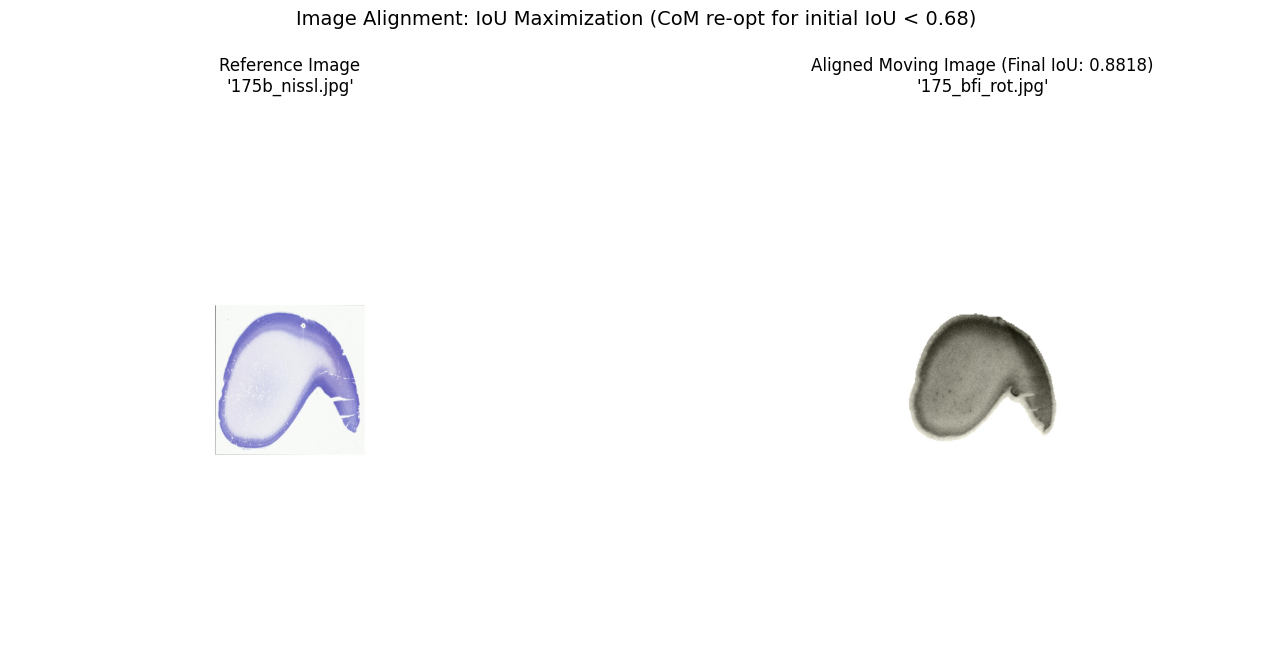

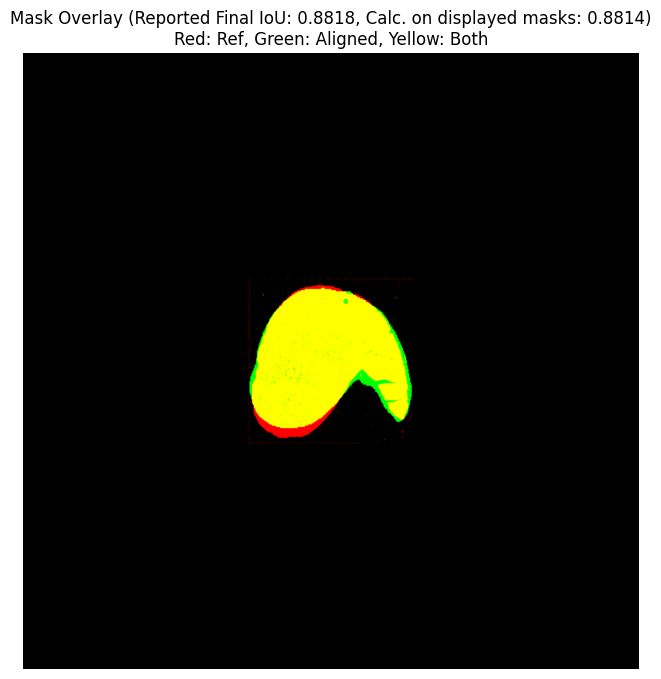

In [4]:
import cv2
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

# --- Configuration ---
# Define the threshold to consider a pixel as "white" (adjust if needed)
# Pixels with grayscale values >= WHITE_THRESHOLD will be considered background.
WHITE_THRESHOLD = 245
IOU_REOPTIMIZATION_THRESHOLD = 0.68 # Threshold to trigger CoM-guided re-optimization

# Optimization settings
OPTIMIZER_METHOD = 'Nelder-Mead' # 'Powell' is another good option
OPTIMIZER_OPTIONS = {'maxiter': 1000, 'xatol': 1e-4, 'fatol': 1e-5, 'disp': True} # Display optimization progress

# --- Helper Functions ---

def create_binary_mask(image, threshold):
    """Creates a binary mask where pixels that are neither pure white nor pure black are 1; pure white or pure black are 0."""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Threshold: Non-white pixels become 255, white pixels become 0
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

    # Ensure pure black is treated as background (0)
    mask[gray == 0] = 0

    # Normalize mask to 0 and 1
    mask = (mask / 255).astype(np.uint8)
    return mask

def calculate_iou(mask1, mask2):
    """Calculates the Intersection over Union (IoU) for two binary masks."""
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    union = np.sum((mask1 > 0) | (mask2 > 0))
    if union == 0:
        return 0.0  # Avoid division by zero
    iou = intersection / union
    return iou

def get_initial_guess(mask1, mask2):
    """Estimates an initial guess for [scale, angle, tx, ty] based on centroids and areas."""
    # Find moments of the largest contour for robust estimation
    contours1, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours1 or not contours2:
        print("Warning: Could not find contours in one or both masks for initial guess. Using default [1,0,0,0].")
        return [1.0, 0.0, 0.0, 0.0]

    contour1 = max(contours1, key=cv2.contourArea)
    contour2 = max(contours2, key=cv2.contourArea)

    M1 = cv2.moments(contour1)
    M2 = cv2.moments(contour2)

    if M1['m00'] == 0 or M2['m00'] == 0:
        print("Warning: Zero area contour found for initial guess. Using default [1,0,0,0].")
        return [1.0, 0.0, 0.0, 0.0]

    # Centroids of largest contours
    cx1, cy1 = M1['m10'] / M1['m00'], M1['m01'] / M1['m00']
    cx2, cy2 = M2['m10'] / M2['m00'], M2['m01'] / M2['m00']

    # Area-based scale estimate
    area1 = M1['m00']
    area2 = M2['m00']
    scale_guess = np.sqrt(area1 / area2) if area2 > 0 else 1.0

    # Initial angle guess (can be improved with orientation estimation if needed)
    angle_guess = 0.0

    # Translation guess: align centroids after scaling and assuming angle_guess=0
    tx_guess = cx1 - scale_guess * cx2
    ty_guess = cy1 - scale_guess * cy2

    print(f"Initial Guess: Scale={scale_guess:.3f}, Angle={angle_guess:.1f}, Tx={tx_guess:.1f}, Ty={ty_guess:.1f}")
    return [scale_guess, angle_guess, tx_guess, ty_guess]


def objective_function(params, mask_ref, mask_moving_orig, ref_shape):
    """
    Objective function to minimize (1 - IoU).
    Applies transformation defined by params to mask_moving_orig and calculates IoU against mask_ref.
    """
    scale, angle, tx, ty = params
    h_mov, w_mov = mask_moving_orig.shape[:2]
    h_ref, w_ref = ref_shape[:2]

    # Center of the moving mask (for rotation/scaling)
    center_x, center_y = w_mov / 2.0, h_mov / 2.0

    # Get the rotation matrix (includes scale)
    M = cv2.getRotationMatrix2D((center_x, center_y), angle, scale)

    # Apply translation to the matrix
    M[0, 2] += tx
    M[1, 2] += ty

    # Warp the *original moving mask* to the reference image's coordinate space
    # Use INTER_NEAREST for binary masks to avoid intermediate values
    warped_mask_moving = cv2.warpAffine(
        mask_moving_orig,
        M,
        (w_ref, h_ref), # Output size = reference mask size
        flags=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0 # Background is 0 in our mask
    )

    # Calculate IoU
    iou = calculate_iou(mask_ref, warped_mask_moving)

    # We want to MAXIMIZE IoU, so we MINIMIZE 1 - IoU
    cost = 1.0 - iou
    # print(f"Params: S={scale:.3f}, A={angle:.2f}, Tx={tx:.1f}, Ty={ty:.1f} -> IoU={iou:.4f}, Cost={cost:.4f}") # Verbose
    return cost

# --- Main Alignment Function ---

def align_images_iou(img_ref_path, img_moving_path):
    """
    Aligns the moving image to the reference image to maximize non-white pixel IoU.
    If initial IoU is below IOU_REOPTIMIZATION_THRESHOLD, attempts CoM-guided re-optimization.

    Args:
        img_ref_path (str): Path to the reference image.
        img_moving_path (str): Path to the moving image.

    Returns:
        tuple: (img_ref, aligned_img_moving, initial_iou, final_iou, optimal_params)
               Returns None if images cannot be loaded or masks are empty.
    """
    # Load images
    img_ref = cv2.imread(img_ref_path)
    img_moving = cv2.imread(img_moving_path)

    if img_ref is None:
        print(f"Error: Could not load reference image at {img_ref_path}")
        return None
    if img_moving is None:
        print(f"Error: Could not load moving image at {img_moving_path}")
        return None

    print(f"Reference Image ('{img_ref_path}') Dimensions: {img_ref.shape}")
    print(f"Moving Image ('{img_moving_path}') Dimensions: {img_moving.shape}")

    # Create binary masks (1 for non-white, 0 for white)
    mask_ref = create_binary_mask(img_ref, WHITE_THRESHOLD)
    mask_moving_orig = create_binary_mask(img_moving, WHITE_THRESHOLD) # Keep original mask for warping

    if np.sum(mask_ref) == 0 or np.sum(mask_moving_orig) == 0:
        print("Error: One or both images appear to be entirely white after thresholding.")
        print(f"Sum of mask_ref: {np.sum(mask_ref)}, Sum of mask_moving_orig: {np.sum(mask_moving_orig)}")
        return None

    # Get initial guess for transformation parameters [scale, angle, tx, ty]
    initial_guess_params = get_initial_guess(mask_ref, mask_moving_orig)

    # Calculate IoU with initial guess (before optimization)
    initial_cost = objective_function(initial_guess_params, mask_ref, mask_moving_orig, mask_ref.shape)
    initial_iou = 1.0 - initial_cost
    print(f"Initial IoU (based on guess): {initial_iou:.4f}")

    # --- First Optimization Attempt ---
    print(f"\nStarting first optimization attempt using {OPTIMIZER_METHOD}...")
    start_time = time.time()
    result = minimize(
        objective_function,
        initial_guess_params,
        args=(mask_ref, mask_moving_orig, mask_ref.shape),
        method=OPTIMIZER_METHOD,
        options=OPTIMIZER_OPTIONS
    )
    end_time = time.time()
    print(f"First optimization finished in {end_time - start_time:.2f} seconds.")

    # Store results of the first attempt
    best_params = result.x
    best_iou = 1.0 - result.fun
    best_result_message = result.message
    best_result_success = result.success

    if not best_result_success:
        print(f"Warning: First optimization failed or did not converge. Reason: {best_result_message}")
    else:
        print(f"First optimization successful: {best_result_message}")
    print(f"IoU after first optimization: {best_iou:.4f}")


    # --- CoM-guided Re-optimization if IoU is low ---
    if best_iou < IOU_REOPTIMIZATION_THRESHOLD and np.sum(mask_ref) > 0 and np.sum(mask_moving_orig) > 0:
        print(f"\nIoU ({best_iou:.4f}) is below threshold ({IOU_REOPTIMIZATION_THRESHOLD}). Attempting CoM-guided re-optimization.")

        # Calculate CoM of reference mask (all non-background pixels)
        M_ref = cv2.moments(mask_ref, binaryImage=True)
        if M_ref['m00'] == 0:
            print("Warning: Reference mask is empty for CoM calculation. Skipping CoM-guided re-optimization.")
        else:
            cx_ref = M_ref['m10'] / M_ref['m00']
            cy_ref = M_ref['m01'] / M_ref['m00']

            # CoM of original moving mask is not directly used here, but good to check
            M_mov_orig_check = cv2.moments(mask_moving_orig, binaryImage=True)
            if M_mov_orig_check['m00'] == 0:
                 print("Warning: Original moving mask is effectively empty. Skipping CoM-guided re-optimization.")
            else:
                # Use scale/angle from the first optimization attempt as a basis
                s_basis = best_params[0]
                a_basis = best_params[1]

                h_mov, w_mov = mask_moving_orig.shape[:2]
                h_ref, w_ref = mask_ref.shape[:2] # Output size for warping
                center_x_mov, center_y_mov = w_mov / 2.0, h_mov / 2.0

                # Create transformation matrix with only s_basis, a_basis (centered on original moving image)
                M_sa_basis = cv2.getRotationMatrix2D((center_x_mov, center_y_mov), a_basis, s_basis)

                # Warp the original moving mask with s_basis, a_basis to find its CoM in the reference frame
                mask_mov_sa_warped = cv2.warpAffine(
                    mask_moving_orig, M_sa_basis, (w_ref, h_ref),
                    flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0
                )
                M_mov_sa_warped = cv2.moments(mask_mov_sa_warped, binaryImage=True)

                if M_mov_sa_warped['m00'] == 0:
                    print("Warning: Moving mask became empty after applying basis scale/angle for CoM. Skipping re-optimization.")
                else:
                    cx_mov_sa = M_mov_sa_warped['m10'] / M_mov_sa_warped['m00']
                    cy_mov_sa = M_mov_sa_warped['m01'] / M_mov_sa_warped['m00']

                    # Calculate the translation (tx, ty) that would align the CoM of the
                    # (s_basis, a_basis)-transformed moving mask with the CoM of the reference mask.
                    # These tx, ty are the new guess for the translational part of the optimization parameters.
                    tx_com_guided = cx_ref - cx_mov_sa
                    ty_com_guided = cy_ref - cy_mov_sa

                    initial_guess_reopt = [s_basis, a_basis, tx_com_guided, ty_com_guided]

                    print(f"CoM-guided Re-opt Initial Guess: Scale={initial_guess_reopt[0]:.3f}, Angle={initial_guess_reopt[1]:.1f}, Tx={initial_guess_reopt[2]:.1f}, Ty={initial_guess_reopt[3]:.1f}")
                    print(f"Starting re-optimization using {OPTIMIZER_METHOD}...")
                    start_time_reopt = time.time()

                    result_reopt = minimize(
                        objective_function,
                        initial_guess_reopt,
                        args=(mask_ref, mask_moving_orig, mask_ref.shape), # Still use original moving mask
                        method=OPTIMIZER_METHOD,
                        options=OPTIMIZER_OPTIONS
                    )
                    end_time_reopt = time.time()
                    print(f"Re-optimization finished in {end_time_reopt - start_time_reopt:.2f} seconds.")

                    current_reopt_iou = 1.0 - result_reopt.fun
                    print(f"IoU after re-optimization: {current_reopt_iou:.4f}")

                    if current_reopt_iou > best_iou:
                        print("Re-optimization resulted in a better IoU.")
                        best_params = result_reopt.x
                        best_iou = current_reopt_iou
                        best_result_message = result_reopt.message
                        best_result_success = result_reopt.success
                        if not result_reopt.success:
                             print(f"Note: Re-optimization technically failed/did not converge ('{result_reopt.message}') but IoU improved.")
                        else:
                             print(f"Re-optimization successful: {best_result_message}")
                    else:
                        if not result_reopt.success:
                             print(f"Warning: Re-optimization failed/did not converge ('{result_reopt.message}') and did not improve IoU. Keeping previous result (IoU: {best_iou:.4f}).")
                        else:
                             print(f"Re-optimization did not improve IoU (New: {current_reopt_iou:.4f} vs Prev: {best_iou:.4f}). Keeping previous result.")

    # Final results after potential re-optimization
    optimal_params = best_params
    final_iou = best_iou

    print(f"\nFinal Optimal Parameters (after potential re-optimization): Scale={optimal_params[0]:.4f}, Angle={optimal_params[1]:.2f} deg, Tx={optimal_params[2]:.2f} px, Ty={optimal_params[3]:.2f} px")
    print(f"Final Maximum IoU: {final_iou:.4f}")

    if not best_result_success: # This reflects the status of the optimization that yielded the 'best_iou'
        print(f"Final optimization status: {best_result_message} (Convergence issue may exist)")
    else:
        print(f"Final optimization status: {best_result_message}")

    # Apply the optimal transformation to the *original color* moving image
    optimal_scale, optimal_angle, optimal_tx, optimal_ty = optimal_params
    h_mov, w_mov = img_moving.shape[:2]
    h_ref, w_ref = img_ref.shape[:2]
    center_x_mov, center_y_mov = w_mov / 2.0, h_mov / 2.0

    # Get the final transformation matrix
    M_final = cv2.getRotationMatrix2D((center_x_mov, center_y_mov), optimal_angle, optimal_scale)
    M_final[0, 2] += optimal_tx
    M_final[1, 2] += optimal_ty

    # Warp the original moving image
    aligned_img_moving = cv2.warpAffine(
        img_moving,
        M_final,
        (w_ref, h_ref), # Output size = reference image size
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(255, 255, 255) # White background
    )

    return img_ref, aligned_img_moving, initial_iou, final_iou, optimal_params

# --- Execution ---

if __name__ == "__main__":
    # --- IMPORTANT: Replace with the actual paths to your images ---
    # Example Usage:
    # reference_image_path = 'path/to/your/nissl_scan.png'
    # moving_image_path = 'path/to/your/bfi_scan.png'

    # Use placeholder images if paths are not provided
    try:
        reference_image_path = '/home/projects/medimg/supriti/brain-registration/142/175b_nissl.jpg' # CHANGE THIS TO YOUR REFERENCE IMAGE
        moving_image_path = '/home/projects/medimg/supriti/brain-registration/142/175_bfi_rot.jpg'    # CHANGE THIS TO YOUR MOVING IMAGE

        # Basic check if files might exist (cv2.imread will confirm later)
        # This is just to trigger dummy image creation if paths are default and likely non-existent
        _ = open(reference_image_path, 'rb')
        _ = open(moving_image_path, 'rb')
        _.close()

    except FileNotFoundError:
         print("\n--- One or both specified image paths not found. ---")
         print("--- Creating Dummy Images for Demonstration ---")
         print("--- Please replace paths with your actual image files for meaningful results ---")

         # Create Reference Image (e.g., a dark rectangle on white background)
         img_ref_dummy = np.full((400, 500, 3), 255, dtype=np.uint8) # White background
         cv2.rectangle(img_ref_dummy, (100, 100), (400, 300), (50, 30, 20), -1) # Dark shape
         cv2.imwrite('/home/projects/medimg/supriti/brain-registration/142/dummy_ref.png', img_ref_dummy)
         reference_image_path = 'dummy_ref.png'

         # Create Moving Image (e.g., a smaller, rotated, translated version of a similar shape)
         img_mov_dummy_content = np.full((180, 220, 3), 255, dtype=np.uint8)
         cv2.rectangle(img_mov_dummy_content, (20, 30), (200, 150), (20, 50, 30), -1) # Slightly different dark shape

         # Apply some transformation for the demo
         h_mdc, w_mdc = img_mov_dummy_content.shape[:2]
         center_mdc = (w_mdc // 2, h_mdc // 2)
         angle = 25
         scale = 0.7
         tx_demo, ty_demo = 60, 45 # Initial offset for the content within its canvas

         M_demo = cv2.getRotationMatrix2D(center_mdc, angle, scale)
         M_demo[0,2] += tx_demo
         M_demo[1,2] += ty_demo

         # Canvas for the moving image (can be different size)
         img_mov_final_canvas = np.full((350, 450, 3), 255, dtype=np.uint8)
         h_canvas, w_canvas = img_mov_final_canvas.shape[:2]

         img_mov_transformed = cv2.warpAffine(img_mov_dummy_content, M_demo, (w_canvas, h_canvas), # Warping onto final canvas size
                                              dst=img_mov_final_canvas, # directly warp into canvas
                                              borderMode=cv2.BORDER_TRANSPARENT) # if areas outside content are transparent
                                                                              # or use borderValue=(255,255,255) if content bg is white

         # Ensure background of transformed part is white if needed, warpAffine with BORDER_TRANSPARENT needs care
         # Simpler: warp to its own size then place. For demo, let's ensure white bg where no content.
         # If img_mov_dummy_content has alpha, BORDER_TRANSPARENT is useful.
         # Assuming opaque, let's use BORDER_CONSTANT with white
         img_mov_transformed = cv2.warpAffine(img_mov_dummy_content, M_demo, (w_canvas, h_canvas),
                                              borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))


         cv2.imwrite('/home/projects/medimg/supriti/brain-registration/142/dummy_mov.png', img_mov_transformed)
         moving_image_path = '/home/projects/medimg/supriti/brain-registration/142/dummy_mov.png'
         print("Created dummy_ref.png and dummy_mov.png for testing.\n")


    # Perform alignment
    alignment_result = align_images_iou(reference_image_path, moving_image_path)

    if alignment_result:
        img_ref, aligned_img_moving, initial_iou, final_iou, params = alignment_result

        # --- Display Results ---
        print("\nDisplaying results...")
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Convert BGR (OpenCV) to RGB (Matplotlib) for display
        img_ref_rgb = cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB)
        aligned_img_moving_rgb = cv2.cvtColor(aligned_img_moving, cv2.COLOR_BGR2RGB)

        axes[0].imshow(img_ref_rgb)
        axes[0].set_title(f"Reference Image\n'{reference_image_path.split('/')[-1]}'")
        axes[0].axis('off')

        axes[1].imshow(aligned_img_moving_rgb)
        axes[1].set_title(f"Aligned Moving Image (Final IoU: {final_iou:.4f})\n'{moving_image_path.split('/')[-1]}'")
        axes[1].axis('off')

        title_str = "Image Alignment: IoU Maximization"
        if initial_iou < IOU_REOPTIMIZATION_THRESHOLD and final_iou > initial_iou : # Check if re-opt was likely attempted and improved
             title_str += f" (CoM re-opt for initial IoU < {IOU_REOPTIMIZATION_THRESHOLD})"

        plt.suptitle(title_str, fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
        plt.show()

        # Optional: Overlay the masks for verification
        mask_ref_final = create_binary_mask(img_ref, WHITE_THRESHOLD)
        # Create mask from the *aligned color image* to see what the final IoU corresponds to visually
        mask_aligned_moving_final = create_binary_mask(aligned_img_moving, WHITE_THRESHOLD)

        # Create color overlay: Red=Ref only, Green=Aligned only, Yellow=Intersection
        overlay = np.zeros((img_ref.shape[0], img_ref.shape[1], 3), dtype=np.uint8)
        # Intersection (Yellow = Red + Green)
        intersection_mask = (mask_ref_final > 0) & (mask_aligned_moving_final > 0)
        # Reference only (Red)
        ref_only_mask = (mask_ref_final > 0) & ~intersection_mask
        # Aligned only (Green)
        aligned_only_mask = (mask_aligned_moving_final > 0) & ~intersection_mask

        overlay[ref_only_mask] = [255, 0, 0]    # Red
        overlay[aligned_only_mask] = [0, 255, 0] # Green
        overlay[intersection_mask] = [255, 255, 0] # Yellow

        plt.figure(figsize=(8, 8))
        plt.imshow(overlay)
        calculated_iou_on_aligned_masks = calculate_iou(mask_ref_final, mask_aligned_moving_final)
        plt.title(f"Mask Overlay (Reported Final IoU: {final_iou:.4f}, Calc. on displayed masks: {calculated_iou_on_aligned_masks:.4f})\nRed: Ref, Green: Aligned, Yellow: Both")
        plt.axis('off')
        plt.show()